# 군집분석

In [8]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN

#경고창 제거
import warnings
warnings.filterwarnings('ignore')


# [직무능력평가]
2가지(계층, K-평균) 군집분석을 실시하고 결과를 해석하시오.

### 1. 데이터 불러오기

In [5]:
df_raw = pd.read_csv("/home/pirl/Downloads/data2/직무능력평가.csv")
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


In [6]:
df_raw_x = df_raw.drop('EVAL', axis=1)
df_raw_y = df_raw['EVAL']

### 2. 데이터 전처리 (표준화)

In [16]:
scaler = StandardScaler()
df_raw_scaled = scaler.fit_transform(df_raw)
df_raw_scaled[:5]

array([[-1.8076031 , -1.19166169, -1.92300586, -1.50494461, -0.35542617,
         1.77141034,  0.20430138],
       [-0.13647543, -0.19861028, -0.17733772, -0.20508842, -0.15977874,
        -0.18159526,  0.4020124 ],
       [ 0.53197564,  0.25972114,  1.23582221,  1.09476777,  1.11192959,
         1.15467173,  0.50086791],
       [-0.30358819, -0.27499885, -0.67610004, -0.81168798, -1.0401922 ,
         0.9490922 , -0.78425369],
       [ 1.36753948,  0.87082969,  0.23829756,  0.83479653,  0.622811  ,
         0.84630243,  0.4020124 ]])

In [17]:
df_raw_y = df_raw_scaled[:,0]
df_raw_x = df_raw_scaled[:,1::]

### 3. Dendrogram

In [18]:
z_ward = linkage(df_raw_x, method='ward', metric='euclidean')
z_average = linkage(df_raw_x, method='average', metric='euclidean')
z_Minkowski= linkage(df_raw_x, method='average', metric='minkowski')

Text(0, 0.5, 'sample index')

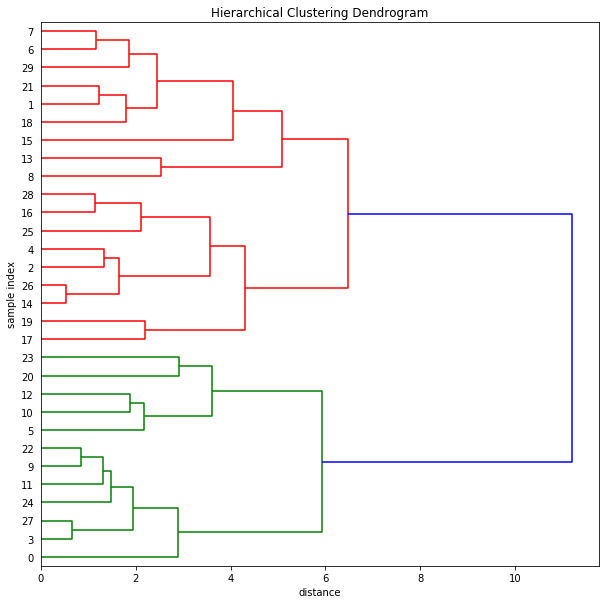

In [19]:
plt.figure(figsize=(10,10))
ax=plt.subplot(111)

dendrogram(z_ward, leaf_font_size=10, orientation='right')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
plt.ylabel('sample index')

Text(0, 0.5, 'sample index')

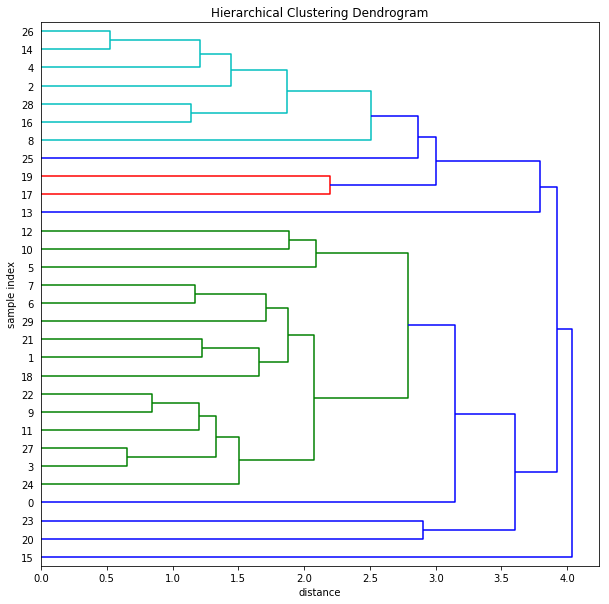

In [20]:
plt.figure(figsize=(10,10))
ax=plt.subplot(111)

dendrogram(z_average, leaf_font_size=10, orientation='right')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
plt.ylabel('sample index')

Text(0, 0.5, 'sample index')

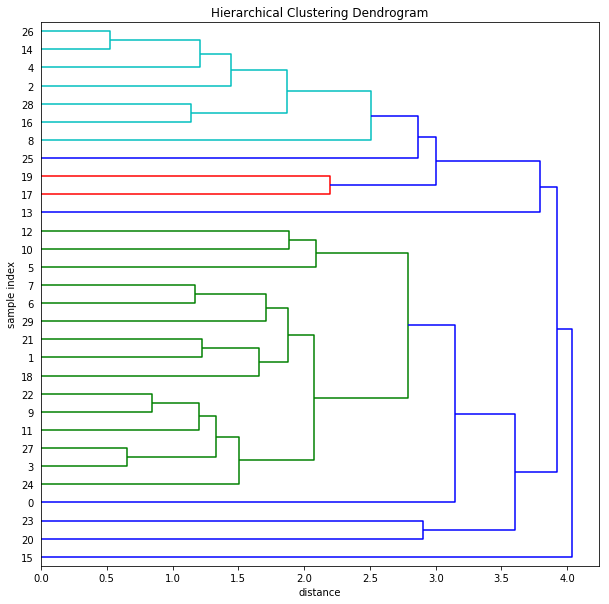

In [21]:
plt.figure(figsize=(10,10))
ax=plt.subplot(111)

dendrogram(z_Minkowski, leaf_font_size=10, orientation='right')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
plt.ylabel('sample index')

In [22]:
#linkage 함수를 통해 얻은 Z_ward 행렬 데이터를 이용하여 군집 생성

cluster_hierarchical = fcluster(Z=z_ward, t=5, criterion='distance')
df_raw['ClusterHierarchical'] = cluster_hierarchical
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,ClusterHierarchical
0,43,51,30,39,61,92,45,1
1,63,64,51,54,63,73,47,5
2,71,70,68,69,76,86,48,3
3,61,63,45,47,54,84,35,1
4,81,78,56,66,71,83,47,3


In [24]:
#군집별 데이터 요약
ds_summary_hc = df_raw.groupby('ClusterHierarchical').agg(['min','mean','max'])

level0 = ds_summary_hc.columns.get_level_values(0)
level1 = ds_summary_hc.columns.get_level_values(1)
ds_summary_hc.columns = level0 + '_' + level1
ds_summary_hc.reset_index(inplace = True)
ds_summary_hc.round(3)

,ClusterHierarchical,EVAL_min,EVAL_mean,EVAL_max,DISSATIS_min,DISSATIS_mean,DISSATIS_max,PRIVILEGE_min,PRIVILEGE_mean,PRIVILEGE_max,...,CHANCE_max,ADVANCE_min,ADVANCE_mean,ADVANCE_max,CRITISM_min,CRITISM_mean,CRITISM_max,PROMOTION_min,PROMOTION_mean,PROMOTION_max
0,1,43,57.429,67,51,58.857,66,30,43.571,52,...,50,51,59.429,66,74,81.143,92,33,38.571,45
1,2,40,53.200,69,37,49.400,62,33,46.800,57,...,58,43,52.000,58,49,60.000,67,25,35.000,49
2,3,50,71.889,85,58,73.889,85,54,63.333,71,...,75,55,74.333,88,74,79.000,86,46,54.667,72
3,4,68,70.000,72,82,82.500,83,72,77.500,83,...,67,59,65.000,71,77,80.000,83,31,33.000,35
4,5,58,69.143,82,61,72.714,90,39,47.143,52,...,72,60,66.286,75,54,72.000,85,35,40.714,47


각 군집별로 다른 통계량 값들을 갖고 있음 (mean값 참고)

### 4. K-평균 군집분석

In [27]:
#군집 개수 찾기
#최대 군집 생성 개수
n_iter_cluster = 15
cluster_range = [i+1 for i in range(n_iter_cluster)]
clus_error=[]
for v_n_clus in cluster_range:
    clus = KMeans(v_n_clus)
    clus.fit(df_raw_x)
    
    clus_error.append(clus.inertia_)
ds_error = pd.DataFrame({'NumberofCluster': cluster_range, 'Error': clus_error})
ds_error

,NumberofCluster,Error
0,1,180.000000
1,2,114.082503
2,3,94.505454
3,4,79.167866
4,5,65.579396
5,6,57.798818
6,7,55.078746
7,8,44.244492
8,9,39.422110
9,10,32.400206


군집 개수가 증가함에 따라 중심점까지의 거리가 가까워진다. 여기서 error는 거리 제곱을 뜻한다.

Text(0, 0.5, 'SUm of squared distance')

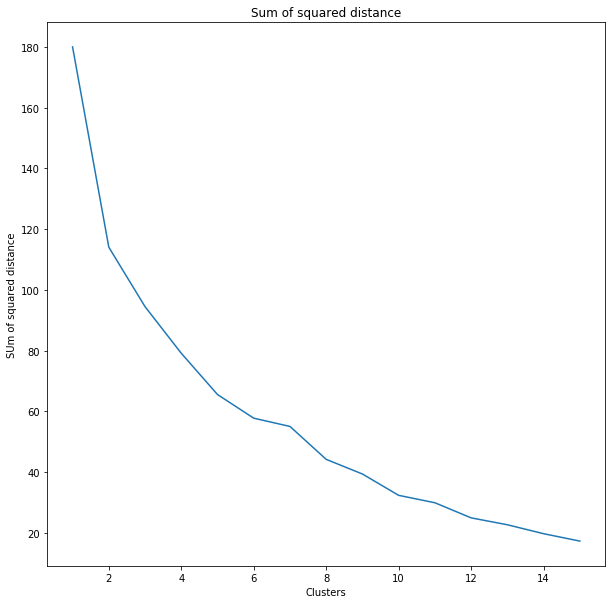

In [28]:
plt.figure(figsize=(10,10))
plt.plot(ds_error['NumberofCluster'], ds_error['Error'])
plt.title('Sum of squared distance')
plt.xlabel('Clusters')
plt.ylabel("SUm of squared distance")

In [29]:
clus = KMeans(5)
clus.fit(df_raw_x)
cluster_kmeans = [i+1 for i in clus.labels_]
df_raw['ClusterKmeans'] = cluster_kmeans
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,ClusterHierarchical,ClusterKmeans
0,43,51,30,39,61,92,45,1,3
1,63,64,51,54,63,73,47,5,1
2,71,70,68,69,76,86,48,3,4
3,61,63,45,47,54,84,35,1,3
4,81,78,56,66,71,83,47,3,4


In [31]:
ds_summary_km = df_raw.drop('ClusterHierarchical',axis=1, inplace=False).\
groupby('ClusterKmeans').agg(['min', 'mean', 'max'])
level0 = ds_summary_km.columns.get_level_values(0)
level1 = ds_summary_km.columns.get_level_values(1)
ds_summary_km.columns = level0 + '_' + level1
ds_summary_km.reset_index(inplace = True)
ds_summary_km.round(3)

,ClusterKmeans,EVAL_min,EVAL_mean,EVAL_max,DISSATIS_min,DISSATIS_mean,DISSATIS_max,PRIVILEGE_min,PRIVILEGE_mean,PRIVILEGE_max,...,CHANCE_max,ADVANCE_min,ADVANCE_mean,ADVANCE_max,CRITISM_min,CRITISM_mean,CRITISM_max,PROMOTION_min,PROMOTION_mean,PROMOTION_max
0,1,58,69.143,82,61,72.714,90,39,47.143,52,...,72,60,66.286,75,54,72.000,85,35,40.714,47
1,2,40,53.200,69,37,49.400,62,33,46.800,57,...,58,43,52.000,58,49,60.000,67,25,35.000,49
2,3,43,57.429,67,51,58.857,66,30,43.571,52,...,50,51,59.429,66,74,81.143,92,33,38.571,45
3,4,66,75.500,85,70,78.625,85,54,63.625,72,...,74,71,77.625,88,74,79.500,86,31,51.375,72
4,5,50,61.000,68,58,67.000,83,65,72.000,83,...,75,55,59.333,64,77,78.333,80,35,49.000,60


### 5. DBSCAN 군집분석

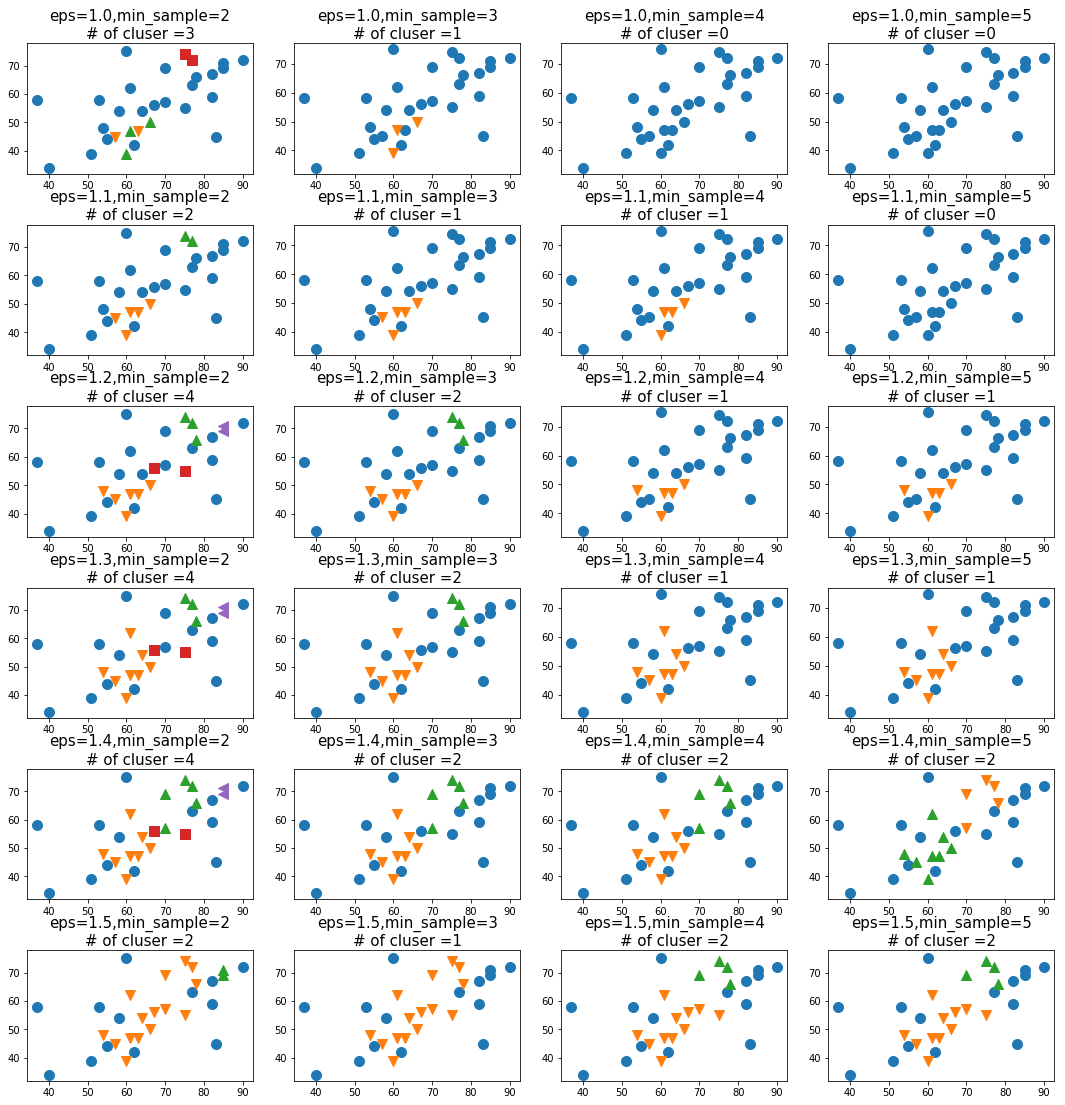

In [34]:
X = df_raw['DISSATIS']
Y = df_raw['CHANCE']

markers = ['o','v','^', 's', '<','>','p','D']

para_eps = [k/10 for k in range(10,16,1)]
para_min_sample = [2,3,4,5]
fig, axes = plt.subplots(len(para_eps), len(para_min_sample),figsize=(15,15))
fig.tight_layout(w_pad=1, h_pad=3)

for i,eps in enumerate(para_eps):
    for j,min_sample in enumerate(para_min_sample):
        dbscan = DBSCAN(min_samples=min_sample, eps=eps)
        clusters = dbscan.fit_predict(df_raw_x)
        clusters = clusters + 1
        for(n_clus, clus) in enumerate(range(min(clusters), max(clusters)+1,1)):
            axes[i,j].scatter(X[clusters == clus], Y[clusters == clus], marker = markers[n_clus], s=100)
            axes[i,j].set_title('eps=' + str(eps) + ',min_sample=' + str(min_sample)+\
                               '\n# of cluser ='+str(max(clusters)), fontsize=15)

* 거리(eps: 두 관측치간의 거리)가 길고 자료수가 적으면 군집이 여러개 생성된다.

: eps=1.4, sample=2 인 경우

* 거리가 짧고 최소 자료수가 많으면 군집이 생성되지 않는다.

: eps=1, samples=5

In [35]:
dbscan = DBSCAN(eps=1.4, min_samples=2).fit(df_raw_x)
cluster_dbscan = dbscan.labels_

for (i,val) in enumerate(cluster_dbscan):
    if val < 0:
        cluster_dbscan[i] = 0
    else:
        cluster_dbscan[i] = cluster_dbscan[i] + 1
df_raw['ClusterDBScan'] = cluster_dbscan
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,ClusterHierarchical,ClusterKmeans,ClusterDBScan
0,43,51,30,39,61,92,45,1,3,0
1,63,64,51,54,63,73,47,5,1,1
2,71,70,68,69,76,86,48,3,4,2
3,61,63,45,47,54,84,35,1,3,1
4,81,78,56,66,71,83,47,3,4,2


In [37]:
ds_summary_db = df_raw.drop(['ClusterHierarchical', 'ClusterKmeans'],
                           axis=1,
                           inplace=False).\
groupby('ClusterDBScan').agg(['min','mean','max'])

level0 = ds_summary_db.columns.get_level_values(0)
level1 = ds_summary_db.columns.get_level_values(1)
ds_summary_db.columns = level0 + '_' + level1
ds_summary_db.reset_index(inplace = True)
ds_summary_db.round(3)

,ClusterDBScan,EVAL_min,EVAL_mean,EVAL_max,DISSATIS_min,DISSATIS_mean,DISSATIS_max,PRIVILEGE_min,PRIVILEGE_mean,PRIVILEGE_max,...,CHANCE_max,ADVANCE_min,ADVANCE_mean,ADVANCE_max,CRITISM_min,CRITISM_mean,CRITISM_max,PROMOTION_min,PROMOTION_mean,PROMOTION_max
0,0,40,61.00,82,37,63.846,90,30,54.385,83,...,75,43,60.154,88,49,70.615,92,25,41.923,72
1,1,48,60.75,67,54,60.750,66,42,47.250,52,...,62,51,60.500,66,73,78.625,84,33,39.125,47
2,2,65,74.40,81,70,74.000,78,46,56.400,68,...,74,71,76.200,80,77,81.800,86,46,47.200,49
3,3,58,64.50,71,67,71.000,75,42,46.000,50,...,56,66,68.000,70,66,67.000,68,35,38.000,41
4,4,74,79.50,85,85,85.000,85,64,67.500,71,...,71,77,78.000,79,74,76.500,79,55,59.000,63
